<a href="https://colab.research.google.com/github/esteban-russi/fraud_detection/blob/main/DS_challenge_esteban_guerrero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FRAUDE CREDITICIO | DATA SCIENCE 🧠**






**OBJETIVOS**


*   Explorar los datos
*   Realizar una categorización de clientes
*   Crear y optimizar un modelo de clasificación para detección de **fraude**



*Elaborado por: Esteban Guerrero Russi*




# Contenido




1. Librerías y Paquetes
2. Carga de datos
3. Definición de funciones
4. Exploratory Data Analysis
5. Preprocesamiento
6. Categorización de clientes
7. Detección de Fraude
8. Conclusiones y próximos pasos






# 1. Librerías y Paquetes

A continuación se presentan las librerías y paquetes de python necesarios para correr este cuadernillo

In [219]:
# Tratamiento y transormación de datos
import pandas as pd
import numpy as np
import ast
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.utils import resample

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns 

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

# Métricas y resulatdos 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

# Optimización de parámetros
from sklearn.model_selection import GridSearchCV

# 2. Carga de datos

In [220]:
data = pd.read_csv('DS Challenge.csv', sep = ';',decimal=',') # Leer los datos del csv suministrado

In [221]:
data.head(3) # Observar los primeros registros de la tabla

ID_USER genero       monto       fecha  hora  \
0        0      F  608.345633  21/01/2020    20   
1        0      F   88.719243  15/01/2020     7   
2        1      F  790.037653  17/01/2020    11   

                                         dispositivo establecimiento  \
0  {'model': 2020; 'device_score': 3; 'os': 'ANDR...           Super   
1  {'model': 2020; 'device_score': 1; 'os': 'ANDR...             NaN   
2      {'model': 2020; 'device_score': 1; 'os': ','}             NaN   

        ciudad  tipo_tc  linea_tc  interes_tc  status_txn  is_prime  \
0       Merida  FÃ­sica     71000          51    Aceptada     False   
1       Merida  Virtual     71000          51    Aceptada     False   
2  Guadalajara  Virtual     94000          56  En proceso     False   

        dcto   cashback  fraude  
0  60.834563   5.475111   False  
1   0.000000   1.774385   False  
2   0.000000  15.800753   False

In [222]:
data.shape # Número de registros y de columnas presentes en la tabla

(26975, 16)

In [223]:
data.info() # Revisión de columnas, tipos de datos y valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26975 entries, 0 to 26974
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID_USER          26975 non-null  int64  
 1   genero           26975 non-null  object 
 2   monto            26975 non-null  float64
 3   fecha            26975 non-null  object 
 4   hora             26975 non-null  int64  
 5   dispositivo      26975 non-null  object 
 6   establecimiento  16856 non-null  object 
 7   ciudad           15297 non-null  object 
 8   tipo_tc          26975 non-null  object 
 9   linea_tc         26975 non-null  int64  
 10  interes_tc       26975 non-null  int64  
 11  status_txn       26975 non-null  object 
 12  is_prime         26975 non-null  bool   
 13  dcto             26975 non-null  float64
 14  cashback         26975 non-null  float64
 15  fraude           26975 non-null  bool   
dtypes: bool(2), float64(3), int64(4), object(7)
memory usage: 

# 3. Definición de funciones

Las funciones que se usan en el cudernillo, se definen y se explican a continuación:

In [224]:
def catplot_vertical(data, col, kind):
  '''
      Realiza un catplot de seaborn adaptado para este ejercicio, considerando la variable fraude  
    
    Args:
      data (pandas dataframe): datos a graficar
      col (string)): nombre de la columna del df
      kind (string)    : tipo de catplot (mismo aceptado por seaborn)
    
    Returns
        visualización
  '''
  # Objeto de visualización
  figure = sns.catplot(data=data, x=col, kind=kind, order=data[col].value_counts(ascending=False).index,
              col='fraude', palette={True:'#FF004F', False:'#00FFBF'}, hue='fraude', sharey=False)

  # Títulos del gráfico
  figure.set_ylabels("Cantidad de operaciones")
  figure.set_xlabels(col)
  plt.suptitle(f"Cantidad de operaciones por {col}, sin fraude y con fraude", y=1.05)

  plt.show()

def boxplot(data,col):
  '''
      Realiza un boxplot de seaborn adaptado para este ejercicio, considerando la variable fraude  
    
    Args:
      data (pandas dataframe): datos a graficar
      col (string)): nombre de la columna del df
          
    Returns
        visualización
  '''

  # Objeto de visualización 
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  # Diagrama de cajas de la izquierda
  sns.boxplot(ax=axes[0],data=data.query('fraude==False'), x=col,color='#00FFBF')
  # Diagrama de cajas de la derecha
  sns.boxplot(ax=axes[1],data=data.query('fraude==True'), x=col,color='#FF004F')

  # Títulos del gráfico
  plt.suptitle(f"Boxplot para variable '{col}', sin fraude y con fraude", y=1.02)
  axes[0].set_title(f"Operaciones sin fraude")
  axes[1].set_title(f"Operaciones con fraude")

  plt.show()

def histplot(data, col, bins):
  '''
      Realiza un histplot de seaborn adaptado para este ejercicio, considerando la variable fraude  
    
    Args:
      data (pandas dataframe): datos a graficar
      col (string)): nombre de la columna del df
          
    Returns
        visualización
  '''

  # Objeto de visualización
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  # Histograma de la izquierda
  sns.histplot(ax=axes[0],data=data.query('fraude==False'), x=col, bins=bins, color='#00FFBF')
  # Histograma de la derecha
  sns.histplot(ax=axes[1],data=data.query('fraude==True'), x=col, bins=bins, color='#FF004F')

  # Títulos y del gráfico
  plt.suptitle(f"Histograma para variable '{col}', sin fraude y con fraude", y=1.02)
  axes[0].set_title(f'Operaciones sin fraude')
  axes[1].set_title(f"Operaciones con fraude")
  axes[0].set_ylabel("Cantidad de operaciones")
  axes[1].set_ylabel("Cantidad de operaciones")
  
  plt.show()


# 4. EDA

El objetivo de esta sección es entender y analizar los datos suminstrados. Para esto, se pasa por cada una de las variables del dataset y adicionalmente se analiza si estas tienen alguna posible relación con el valor de la clase (Fraude)

####Revisión General

Primero se hace una revisión estadística general de los campos numéricos:

En algunas variables se observan distribuciones relativamente iguales entre los diferentes cuartiles, esto se observará en el detalle más adelante. 

In [225]:
data.describe()

ID_USER         monto          hora      linea_tc    interes_tc  \
count  26975.000000  26975.000000  26975.000000  26975.000000  26975.000000   
mean    2003.765412    499.069493     11.987618  62476.811863     48.224875   
std     1144.630736    289.309518      6.642565  21886.892902      9.587256   
min        0.000000      0.017303      1.000000  25000.000000     32.000000   
25%     1041.000000    246.521227      6.000000  44000.000000     40.000000   
50%     2006.000000    500.501022     12.000000  62000.000000     48.000000   
75%     2973.500000    749.598192     18.000000  82000.000000     57.000000   
max     3999.000000    999.917764     23.000000  99000.000000     64.000000   

               dcto      cashback  
count  26975.000000  26975.000000  
mean      17.466134      6.261186  
std       34.334566      4.458440  
min        0.000000      0.000138  
25%        0.000000      2.791740  
50%        0.000000      5.636711  
75%       18.770710      8.531604  
max      199.356251     19.991582

Identificación de valores nulos

In [226]:
data.isna().sum() # Cantidad de valores nulos por variable 

ID_USER                0
genero                 0
monto                  0
fecha                  0
hora                   0
dispositivo            0
establecimiento    10119
ciudad             11678
tipo_tc                0
linea_tc               0
interes_tc             0
status_txn             0
is_prime               0
dcto                   0
cashback               0
fraude                 0
dtype: int64

In [227]:
(data.isna().sum()/data.shape[0])*100 #Proporción de valores nulos por variable

ID_USER             0.000000
genero              0.000000
monto               0.000000
fecha               0.000000
hora                0.000000
dispositivo         0.000000
establecimiento    37.512512
ciudad             43.291937
tipo_tc             0.000000
linea_tc            0.000000
interes_tc          0.000000
status_txn          0.000000
is_prime            0.000000
dcto                0.000000
cashback            0.000000
fraude              0.000000
dtype: float64

In [228]:
print(f'% total de valores nulos: {round(data.isna().sum().sum()/(data.shape[0]*data.shape[1])*100,3)}%')

% total de valores nulos: 5.05%


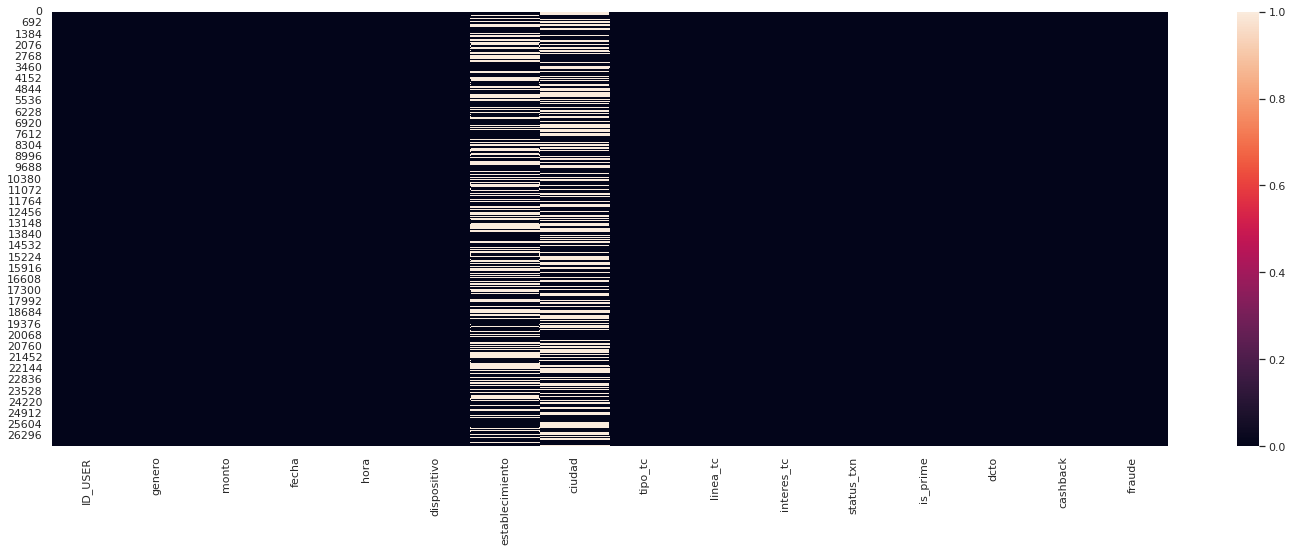

In [229]:
#@title
sns.heatmap(data.isna())
sns.set(rc={'figure.figsize': (25, 8)})
plt.show()

Las columnas establecimiento y ciudad presentan 37.5% y 43.4% de valores nulos respectivamente. Más adelante se deberá decidir si es posible una imputación, eliminación los registros correspondientes o no considerar estas variables para la predicción.  

####Fraude

In [230]:
round(data['fraude'].value_counts(normalize=True)*100,2)

False    97.0
True      3.0
Name: fraude, dtype: float64

La clase 'fraude' se encuentra desbalanceada en el conjunto de datos, esto puede llevar a que el modelo prediga la mayor cantidad de resultados operaciones como Falso (Sin fraude) lo que puede conllevar a muchos errores tipo II (Falsos negativos) y por lo tanto pérdidas monetarias enormes para el banco. 

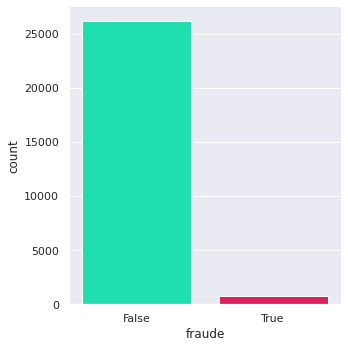

In [231]:
#@title
sns.catplot(data=data, x="fraude", kind='count', order=data['fraude'].value_counts(ascending=False).index, 
            palette={True:'#FF004F', False:'#00FFBF'})
plt.show()

####ID_USER

In [232]:
#@title
print(f'Cantidad de usuarios únicos: {data.ID_USER.nunique()}')

Cantidad de usuarios únicos: 4000


Las 26975 operaciones fueron realizadas entre 4000 usuarios del banco presentes en el dataset.

####Género

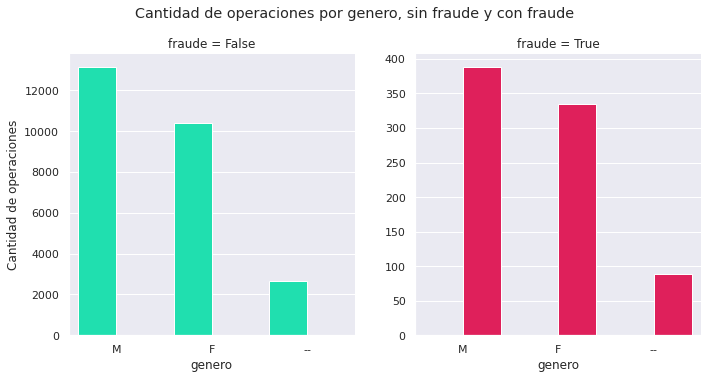

In [233]:
#@title
catplot_vertical(data, 'genero', 'count')

Tanto en operaciones de fraude como en las que no, hay un mayor volúmen realizadas correspondientes a hombres (M), adicionalmente una cantidad quedan como "--", de los que se asume que no quisieron compartir su género o que no se identifican dentro del grupo de hombres o mujeres. 

####Monto

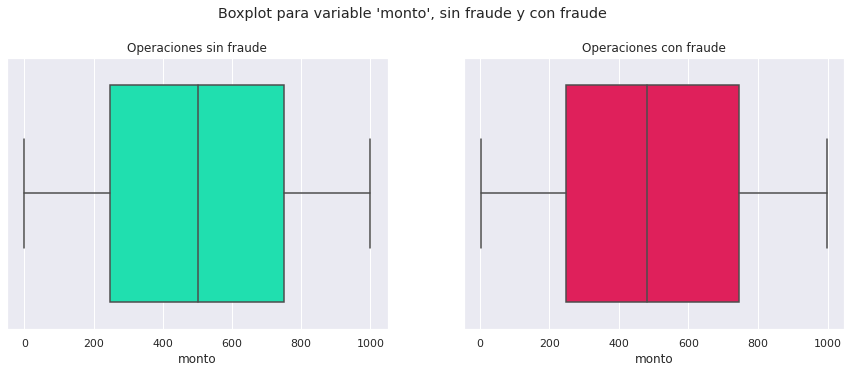

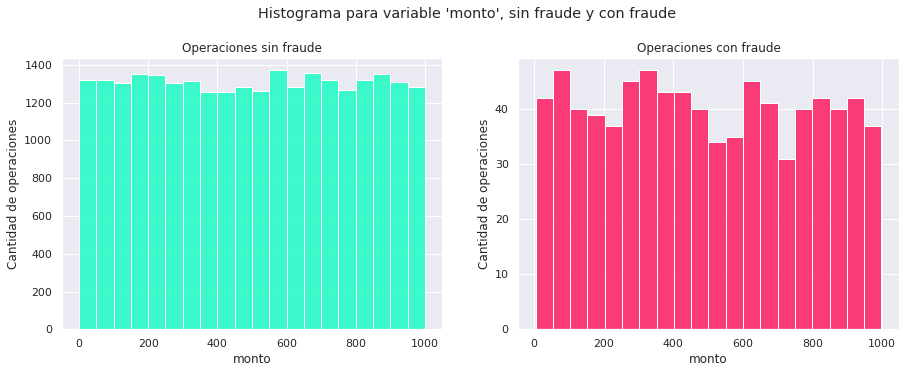

In [234]:
#@title
col = 'monto'
boxplot(data,col)
print("")
histplot(data, col, 20)

Aunque los valores de los montos se encuentran distribuidos de manera similar entre cuartiles y los rangos son iguales, se observan rangos donde se han identificado mayor cantidad de operaciones fraudulentas.  

####Fecha

In [235]:
data['fecha']=pd.to_datetime(data['fecha'])

In [236]:
data['fecha'].nunique()

29

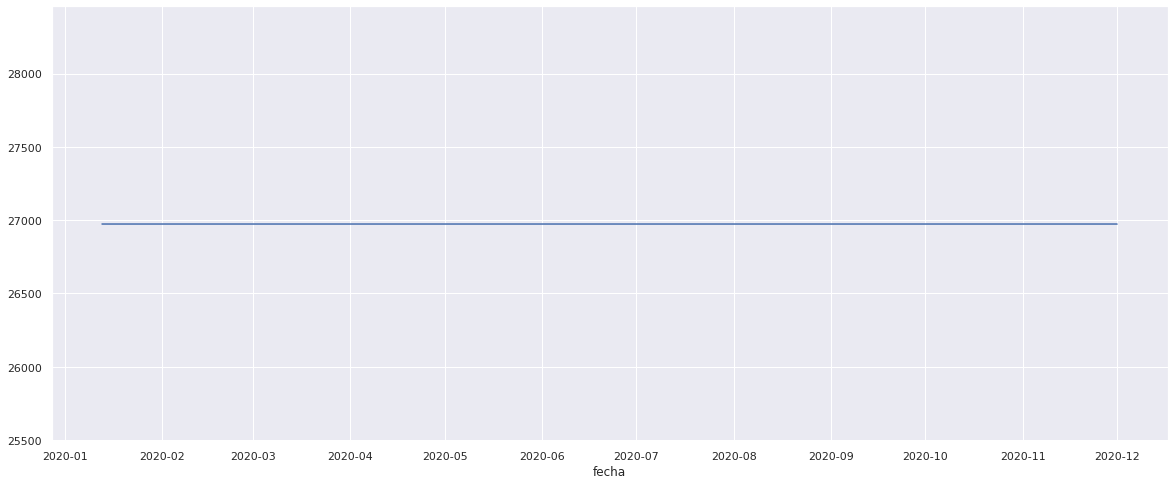

In [237]:
#@title
plt.figure(figsize=(20,8))
sns.lineplot(data=data, x="fecha", y=data.ID_USER.count(), palette="viridis")
plt.show()

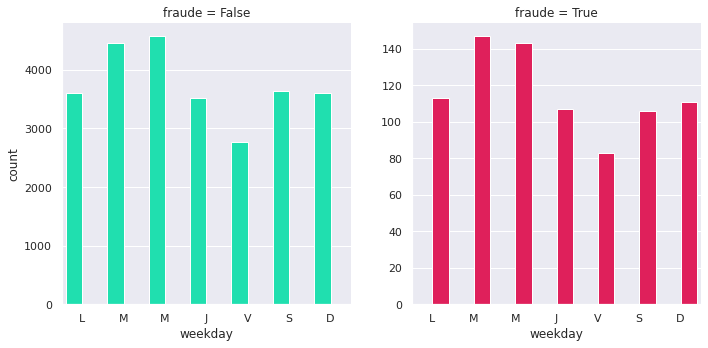

In [238]:
#@title
data['weekday']=data.fecha.dt.weekday
g=sns.catplot(data=data, x='weekday', kind='count',palette={True:'#FF004F', False:'#00FFBF'}, hue='fraude',col='fraude',sharey=False)
g.set_xticklabels(['L','M','M','J','V','S','D'])
plt.show()

Las operaciones del dataset se encuentran dentro de 29 fechas del año 2020 distribuidas de manera igual, adicionalmente no se observa que haya comportamientos diferenciados por día de la semana a nivel de fraude. 

####Hora

In [239]:
data['hora'].nunique()

23

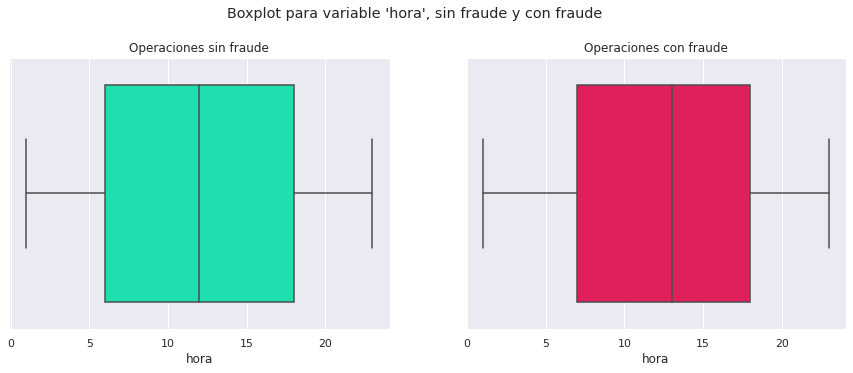

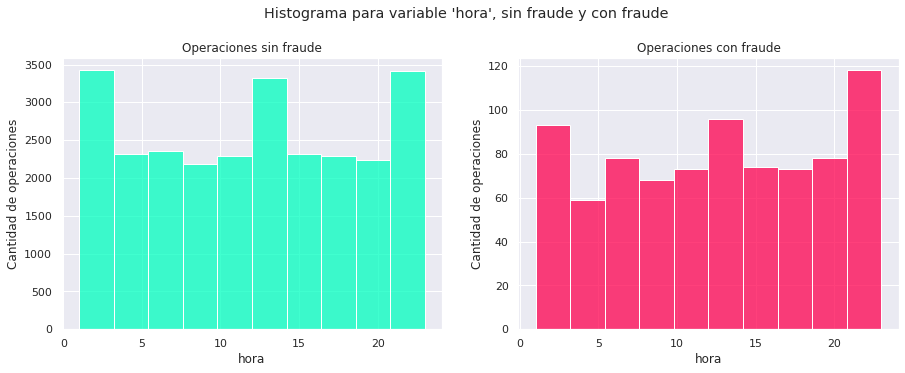

In [240]:
#@title
col = 'hora'
boxplot(data,col)
print("")
histplot(data, col, 10)

El mayor volúmen de operaciones son realizadas en la madrugada, a medio día y en horas de la noche. Las operaciones de fraude tienden a realizarse más en horas tardias de la noche. 

####Dispositivo

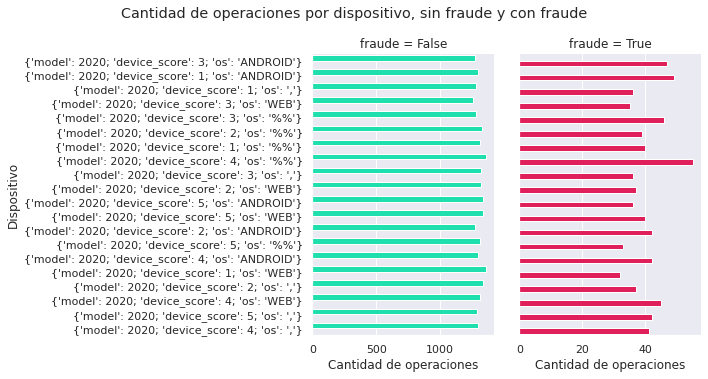

In [241]:
#@title
figure = sns.catplot(data=data, y="dispositivo", kind='count', 
            col='fraude', palette={True:'#FF004F', False:'#00FFBF'}, hue='fraude', sharex=False)
figure.set_xlabels('Cantidad de operaciones')
figure.set_ylabels('Dispositivo')
plt.suptitle("Cantidad de operaciones por dispositivo, sin fraude y con fraude", y=1.05)
plt.show()

No se observa algún dispositivo relevante en relación con el fraude, sin embargo, el campo contiene información que se puede analizar de manera separada como el **modelo, puntaje del dispositivo y sistema operativo.**

In [242]:
# Reemplazar ";" por "," para dar estructura de diccionario
data['dispositivo'] = data['dispositivo'].str.replace(';',",")
# Convertir el valor tipo string en un objeto de diccionario real
data['dispositivo'] = data['dispositivo'].apply(lambda x: ast.literal_eval(x))

In [243]:
# Crear nuevas columnas en el dataset para las llaves del diccionario disposible en la columna 'dispositivo'
keys = ['model','device_score','os']
for i in keys: data[i] = data['dispositivo'].apply(lambda x: x.get(i))

Se analizan las variables extraidas (sistema operativo y device_score) en relación a la variable de interés 'fraude'. No se analiza la variable de modelo debido a que todos los dispositivos son modelo 2020.

##### device_score

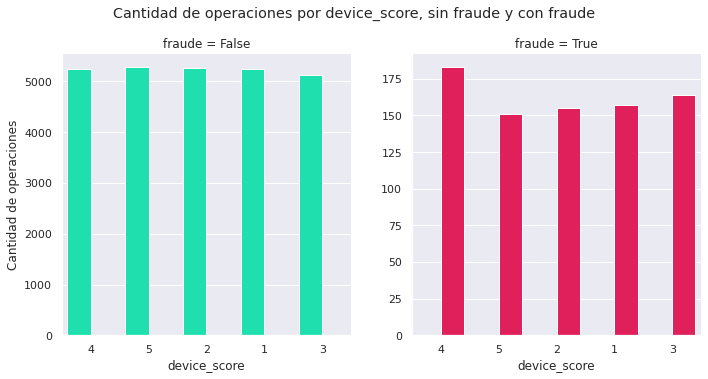

In [244]:
catplot_vertical(data, 'device_score', 'count')

Aunque no se tiene contexto de cómo se otorga la calificación por dispositivo, llama la atención que aquellas transacciones de fraude, se realizan en mayor cantidad con dispositivos de calificación 4, aunque la diferencia no es significativa.  

##### Sistema Operativo (os)

In [245]:
data['os'].value_counts()

%%         6808
WEB        6766
,          6715
ANDROID    6686
Name: os, dtype: int64

Se dejan los sistemas operativos registrados como '%%' y como ',' asignados a una misma categoria 'os_no_identificado'

In [246]:
data['os']=data['os'].str.replace(",",'os_no_identificado')
data['os']=data['os'].str.replace("%%",'os_no_identificado')

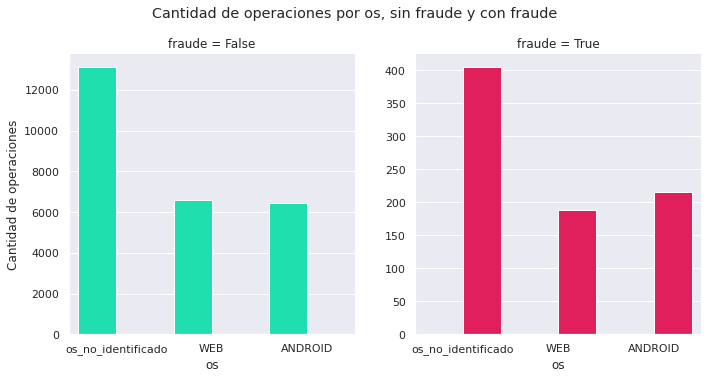

In [247]:
#@title
catplot_vertical(data, 'os', 'count')

La mayor cantidad de operaciones se realizan con dispositivos de sistema operativo no identificado, esto no marca ninguna diferencia al analizar solo operaciones de fraude.

####Establecimiento

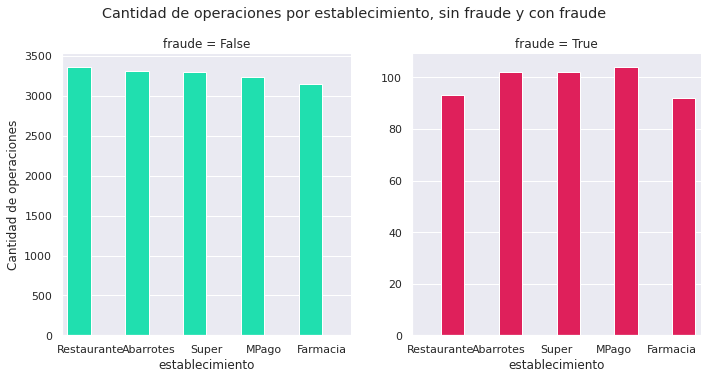

In [248]:
#@title
catplot_vertical(data, 'establecimiento', 'count')

No se observa una diferencia relevante entre los diferentes establecimientos desde los que se realizan las operaciones.  

####Ciudad

In [249]:
data.ciudad.value_counts()

Toluca         3997
Guadalajara    3833
Merida         3761
Monterrey      3706
Name: ciudad, dtype: int64

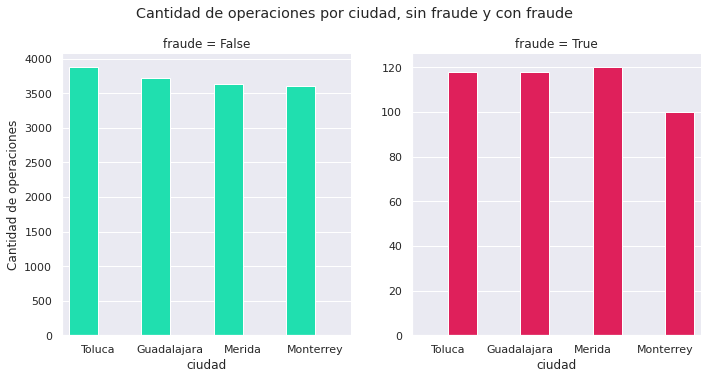

In [250]:
#@title
catplot_vertical(data, 'ciudad', 'count')

La ciudad tampoco parece ser un factor diferenciador a nivel de fraude y a nivel general las 4 ciudades de méxico presentan un volúmen de transacciones entre 3700 y 4000.

####Tipo_tc

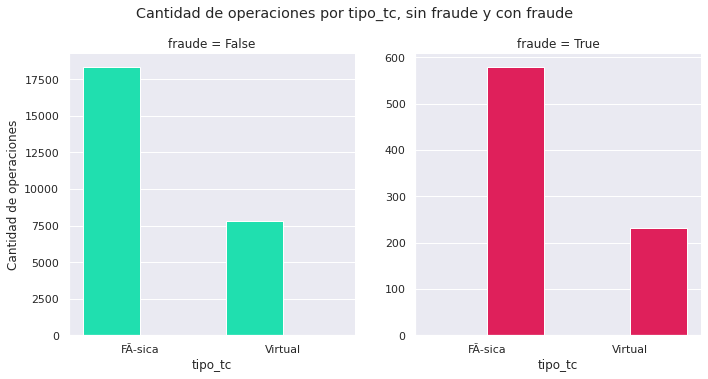

In [251]:
#@title
catplot_vertical(data, 'tipo_tc', 'count')

En general la mayor cantidad de operaciones se realizan usando tarjeta física, proporcionalidad que se mantiene si analizamos solo operaciones con fraude. 

####Linea_tc

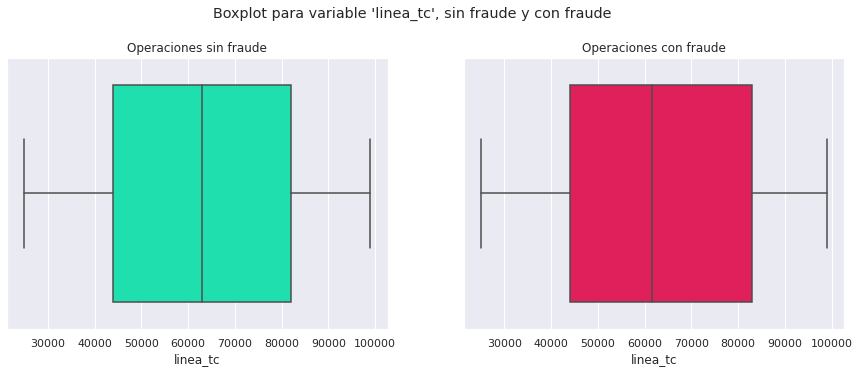

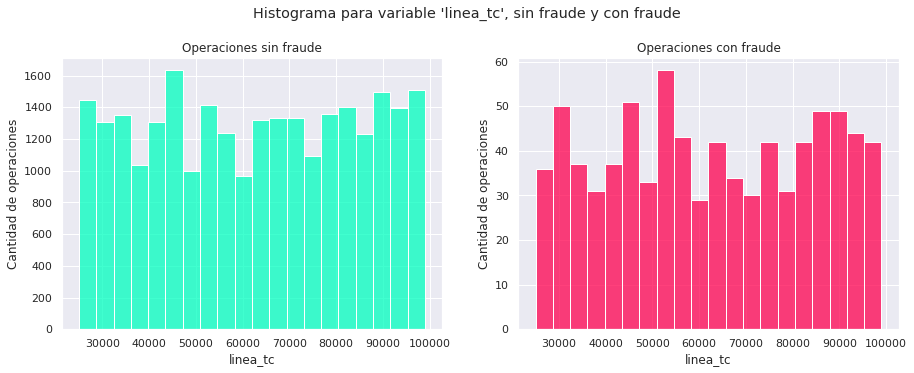

In [252]:
#@title
col = 'linea_tc'
boxplot(data,col)
print("")
histplot(data, col, 20)

La linea de tarjeta de crédito tiene distribuciones similares entre ambas variables, en ambos casos tanto la media como la mediana se encuentran alrededor de 62000.

####interes_tc

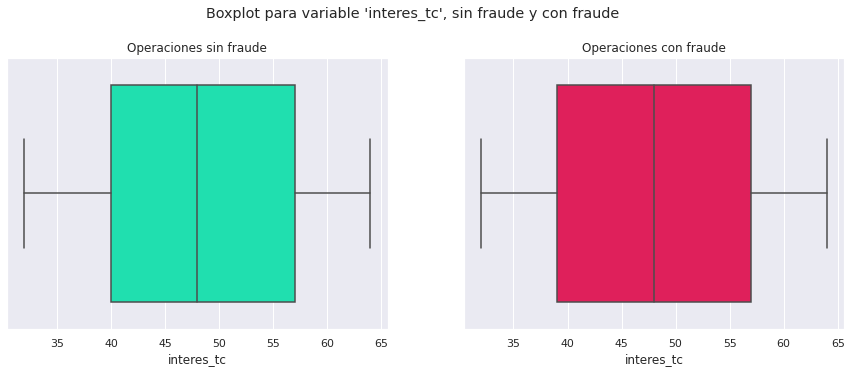

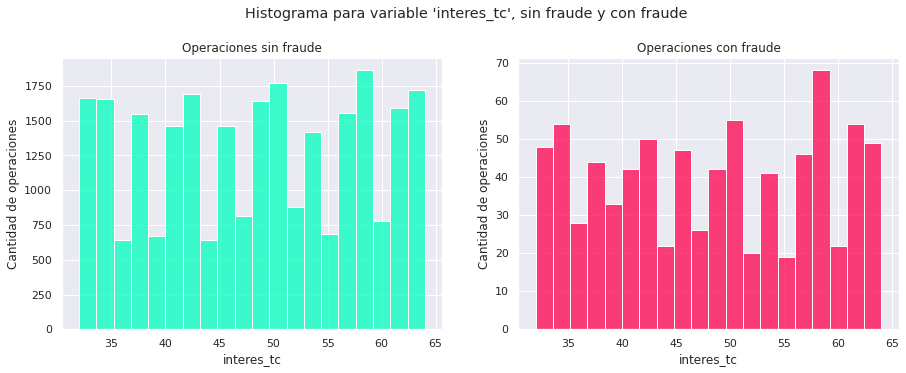

In [253]:
#@title
col = 'interes_tc'
boxplot(data,col)
print("")
histplot(data, col, 20)

Las distribuciones para la variable de interés son similares entre operaciones fraudulentas y legítimas. Lo que inicialmente no demuestra una relación visible entre el fraude y el valor del interés. 

####Status

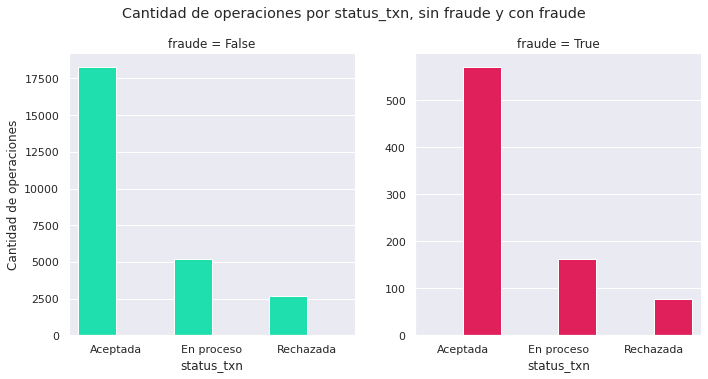

In [294]:
#@title
catplot_vertical(data, 'status_txn', 'count')

Se observa que la mayor parte de transacciones con fraude son aceptadas. Lo que llama la atención porque demuestra que los sistemas de partida no tienen la capacidad para identificar este tipo de operaciones.

####Is Prime

In [255]:
data.is_prime.value_counts()

False    23416
True      3559
Name: is_prime, dtype: int64

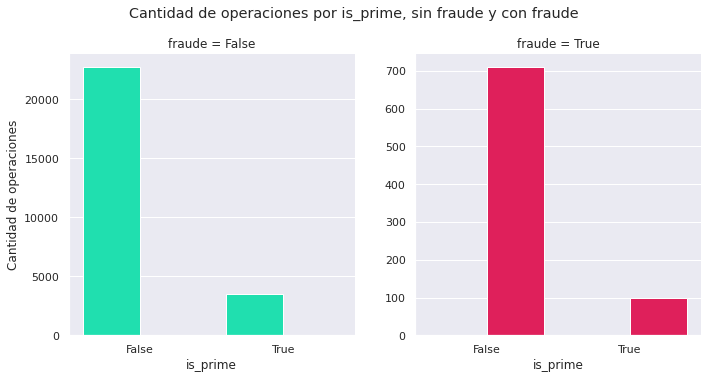

In [256]:
#@title
catplot_vertical(data, 'is_prime', 'count')

Se observa una mayor cantidad de operaciones por usuarios que no son de categoría 'prime', relación que se mantiene para operaciones identificadas como fraude.

####Descuento (dcto)

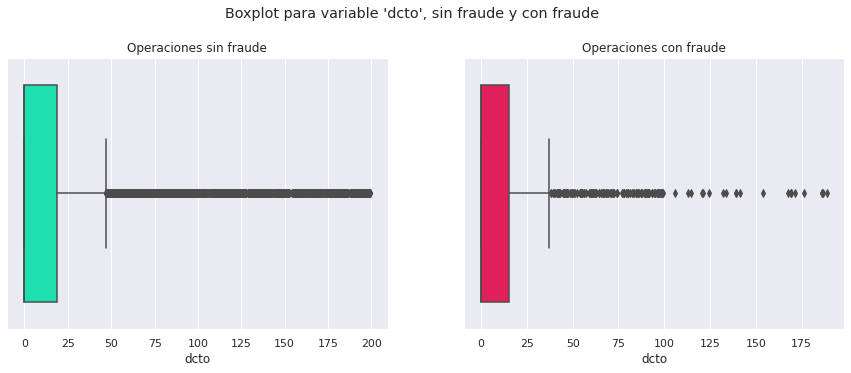

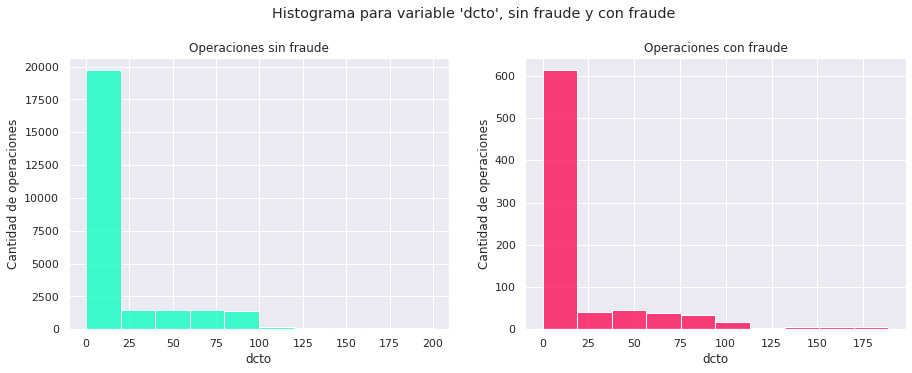

In [257]:
#@title
col = 'dcto'
boxplot(data,col)
print("")
histplot(data, col, 10)

El valor del descuento se encuentra en su mayoría en un rango entre 0 y 25, aunque se observan valores atípicos con descuentos que llegan hasta 200 en operaciones legítimas y hasta 180 en operaciones de fraude.

####Cashback

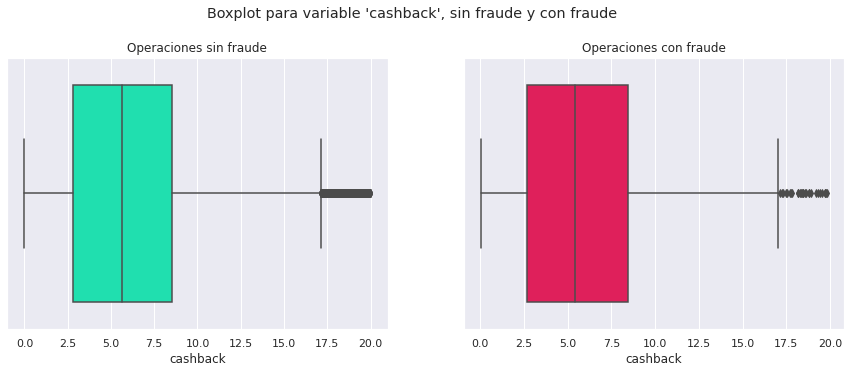

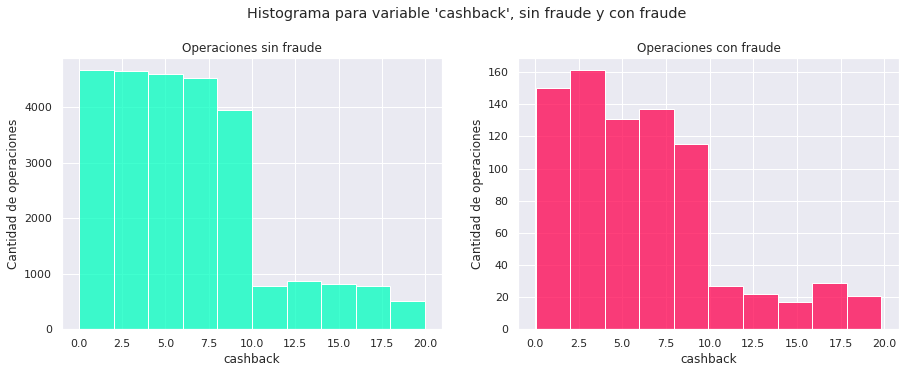

In [258]:
#@title
col = 'cashback'
boxplot(data,col)
print("")
histplot(data, col, 10)

El descuento parece estar con una distribución asimétrica (right-skewed), agrupando la mayor parte de sus valores para la variable 'cashback' entre 0 y 10. Pero con valores que llegan hasta 20 para algunas operaciones. Este mismo comportamiento de distribución aplica para operaciones con fraude. 

# 5. Preprocesamiento

Los modelos que se trabajaran más adelante requieren datos diferentes, por lo tanto diferenciaremos los datasets de la siguiente manera:


*   kmdata: Datos que serán usados para K-means
*   clsdata: Datos que serán usados para modelo de clasificación





###kmdata

##### Definición de parámetros RFM 

Para la categorización de clientes nos basaremos en los siguientes 3 criterios:


*   Recency: Días transcurridos desde que se realizó la última transacción.
*   Frequency: Cantidad de operaciones realizadas.
*   Monetary Value: Monto total de las transacciones realizadas.

De acuerdo a esto, se propondrá una clasificación que permita al banco identificar a sus clientes de mayor valor frente a aquellos que no lo son pero que tienen potencial de serlo. 





In [259]:
## Crear las columnas para el dataframe 

# Fecha actual
actual = data.fecha.max() + pd.Timedelta(days=1)

# Recency
recency = data[['ID_USER','fecha']].groupby('ID_USER').max().reset_index() # Creación data
recency['Recency'] = (actual - recency['fecha']).dt.days   # Calculo dias transcurridos desde la ultima transacción

# Creación columna Frequency
frequency = data[['ID_USER','fecha']].groupby('ID_USER').count().reset_index() # Creación data
frequency.rename(columns={'fecha':'Frequency'},inplace=True)   # Cambio de nombre

# Creación columna monetary_value
monetary_value = data[['ID_USER','monto']].groupby('ID_USER').sum().reset_index() # Creación data
monetary_value.rename(columns={'monto':'MonetaryValue'},inplace=True)  # Cambio de nombre

## Unir los datos en un solo dataframe
df = recency.merge(frequency, on ='ID_USER', how = 'left') \
    .merge(monetary_value, on ='ID_USER', how = 'left') \
    .drop(columns =['fecha'])

# Ver los datos de trabajo
df.head()

ID_USER  Recency  Frequency  MonetaryValue
0        0      316          2     697.064876
1        1       31          7    3416.796066
2        2      123          7    2789.893416
3        3      311          2     477.972148
4        4      310          1     277.176524

A continuación se revisarán las distribuciones y resumen estadístico de las 3 variables de interés

In [260]:
#@title
# Seleccionar columnas para la agrupación
columns_for_clustering = ["Recency", "Frequency", "MonetaryValue"]

# Crear un nuevo DataFrame con las variables de agrupación
df_features = df[columns_for_clustering]

# Imprimir un resumen de los estadísticos descriptivos
df_features.describe()

Recency   Frequency  MonetaryValue
count  4000.000000  4000.00000    4000.000000
mean    133.438000     6.74375    3365.599891
std     117.620805     6.18281    3176.934977
min       1.000000     1.00000       2.038424
25%      31.000000     2.00000    1073.552945
50%      92.000000     5.00000    2358.794303
75%     245.000000     9.00000    4574.230140
max     324.000000    62.00000   32756.785742

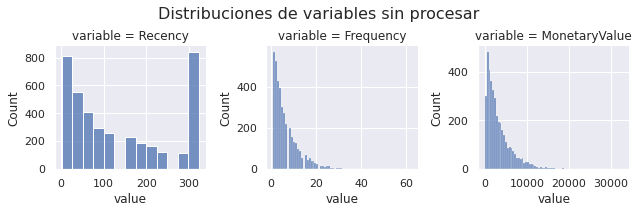

In [261]:
#@title
# Trazar las distribuciones de las variables seleccionadas
g = sns.FacetGrid(
    df_features.melt(),  
    col="variable",  
    sharey=False, 
    sharex=False,
)
# Crea un histograma para el grid
g.map(sns.histplot, "value")
# Titulos
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Distribuciones de variables sin procesar", fontsize=16)
plt.show()

Debido a las distribuciones con cola hacia la derecha (right-skewed) que tienen las variables, se procede a realizar una transformación logarítmica y a normalizar los datos para que estos queden en escalas similares. 

##### Transformación Logarítmica y normalización

In [262]:
# Se asigna el Id de usuario como índice de la tabla
df.set_index('ID_USER',inplace=True)

In [263]:
# Aplicar transformación
df_log = np.log(df)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(df_log)

# Scale and center the data
df_normalized = scaler.transform(df_log)

# Create a pandas DataFrame
df_normalized = pd.DataFrame(data=df_normalized, index=df.index, columns=df.columns)

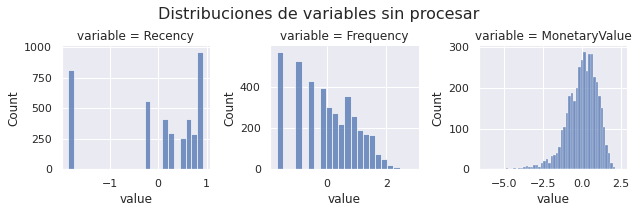

In [264]:
#@title
# Trazar las distribuciones de las variables seleccionadas
g = sns.FacetGrid(
    df_normalized.melt(),  
    col="variable",  
    sharey=False, 
    sharex=False,
)
# Crea un histograma para el grid
g.map(sns.histplot, "value")
# Titulos
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("Distribuciones de variables sin procesar", fontsize=16)
plt.show()

Se observa un cambio en la inclinación de las distribuciones y con la normalización quedan todas en rangos de valores más comparables entre sí. Finalmente, creamos copiamos los datos a kmdata que serán usados para la clusterización.  

In [265]:
kmdata = df_normalized.copy()

###clsdata

Para la detección de fraude se usará un modelo de clasificación usando la librería sckit-learn. Para esto, dejaremos los datos como numéricos y sin valores nulos.

##### Datos categóricos a numericos (Dummie variables) 

In [266]:
clsdata = data.copy()

Primero eliminamos las variables que no tendremos en cuenta para la predicción. Establecimiento y ciudad además de tener un volúmen alto de valores nulos, no demuestran tener una diferenciación relevante en relación al fraude, al igual que dispositivo. Las variables model y fecha son constantes para todas las operaciones, por lo que tampoco representan un valor diferenciador. 

In [267]:
clsdata.drop(['ID_USER','establecimiento','ciudad','dispositivo','model','fecha'], axis=1, inplace=True)

Procedemos a crear *dummie variables* para las columnas categoricas usando la función get_dummies:

In [268]:
cat_features = ['genero', 'tipo_tc', 'status_txn', 'os']

In [269]:
for i in cat_features:
  dummie_df = pd.get_dummies(clsdata[i])
  clsdata = pd.concat([clsdata, dummie_df], axis=1)
  clsdata = clsdata.drop(i, axis=1)

Transformar variables boolean en tipo integer (True = 1, False = 0)

In [270]:
clsdata.is_prime = clsdata.is_prime.astype(int)
clsdata.fraude = clsdata.fraude.astype(int)

In [271]:
clsdata.describe()

monto          hora      linea_tc    interes_tc      is_prime  \
count  26975.000000  26975.000000  26975.000000  26975.000000  26975.000000   
mean     499.069493     11.987618  62476.811863     48.224875      0.131937   
std      289.309518      6.642565  21886.892902      9.587256      0.338429   
min        0.017303      1.000000  25000.000000     32.000000      0.000000   
25%      246.521227      6.000000  44000.000000     40.000000      0.000000   
50%      500.501022     12.000000  62000.000000     48.000000      0.000000   
75%      749.598192     18.000000  82000.000000     57.000000      0.000000   
max      999.917764     23.000000  99000.000000     64.000000      1.000000   

               dcto      cashback        fraude       weekday  device_score  \
count  26975.000000  26975.000000  26975.000000  26975.000000  26975.000000   
mean      17.466134      6.261186      0.030028      2.865987      3.002595   
std       34.334566      4.458440      0.170667      1.994734      1.417432   
min        0.000000      0.000138      0.000000      0.000000      1.000000   
25%        0.000000      2.791740      0.000000      1.000000      2.000000   
50%        0.000000      5.636711      0.000000      3.000000      3.000000   
75%       18.770710      8.531604      0.000000      5.000000      4.000000   
max      199.356251     19.991582      1.000000      6.000000      5.000000   

       ...             F             M       FÃ­sica       Virtual  \
count  ...  26975.000000  26975.000000  26975.000000  26975.000000   
mean   ...      0.397627      0.501168      0.700760      0.299240   
std    ...      0.489417      0.500008      0.457934      0.457934   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      1.000000      1.000000      0.000000   
75%    ...      1.000000      1.000000      1.000000      1.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

           Aceptada    En proceso     Rechazada       ANDROID           WEB  \
count  26975.000000  26975.000000  26975.000000  26975.000000  26975.000000   
mean       0.698573      0.197998      0.103429      0.247859      0.250825   
std        0.458886      0.398498      0.304524      0.431778      0.433496   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       os_no_identificado  
count        26975.000000  
mean             0.501316  
std              0.500008  
min              0.000000  
25%              0.000000  
50%              1.000000  
75%              1.000000  
max              1.000000  

[8 rows x 21 columns]

Teniendo todos los datos como numéricos ahora debemos normalizar para dejarlos en una misma escala

##### Normalización

In [272]:
for i in ['monto','linea_tc','dcto','cashback','interes_tc','hora']:
  clsdata[i] = scale(clsdata[i])

In [273]:
clsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26975 entries, 0 to 26974
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   monto               26975 non-null  float64
 1   hora                26975 non-null  float64
 2   linea_tc            26975 non-null  float64
 3   interes_tc          26975 non-null  float64
 4   is_prime            26975 non-null  int64  
 5   dcto                26975 non-null  float64
 6   cashback            26975 non-null  float64
 7   fraude              26975 non-null  int64  
 8   weekday             26975 non-null  int64  
 9   device_score        26975 non-null  int64  
 10  --                  26975 non-null  uint8  
 11  F                   26975 non-null  uint8  
 12  M                   26975 non-null  uint8  
 13  FÃ­sica             26975 non-null  uint8  
 14  Virtual             26975 non-null  uint8  
 15  Aceptada            26975 non-null  uint8  
 16  En p

Nos aseguramos que los datos queden en el formato y escalas deseadas para aplicar a nuestro modelo

In [274]:
clsdata.head()

monto      hora  linea_tc  interes_tc  is_prime      dcto  cashback  \
0  0.377721  1.206240  0.389427    0.289465         0  1.263136 -0.176315   
1 -1.418404 -0.750871  0.389427    0.289465         0 -0.508714 -1.006380   
2  1.005752 -0.148683  1.440304    0.811001         0 -0.508714  2.139704   
3  0.926139 -0.148683  1.440304    0.811001         0 -0.508714  0.316006   
4 -0.846509 -0.299230  1.440304    0.811001         0 -0.508714 -0.834270   

   fraude  weekday  device_score  ...  F  M  FÃ­sica  Virtual  Aceptada  \
0       0        1             3  ...  1  0        1        0         1   
1       0        2             1  ...  1  0        0        1         1   
2       0        4             1  ...  1  0        0        1         0   
3       0        4             3  ...  1  0        1        0         1   
4       0        3             3  ...  1  0        1        0         1   

   En proceso  Rechazada  ANDROID  WEB  os_no_identificado  
0           0          0        1    0                   0  
1           0          0        1    0                   0  
2           1          0        0    0                   1  
3           0          0        0    1                   0  
4           0          0        0    0                   1  

[5 rows x 21 columns]

In [275]:
clsdata.describe()

monto          hora      linea_tc    interes_tc      is_prime  \
count  2.697500e+04  2.697500e+04  2.697500e+04  2.697500e+04  26975.000000   
mean  -1.538302e-16  1.053631e-18  1.791174e-17 -1.538302e-16      0.131937   
std    1.000019e+00  1.000019e+00  1.000019e+00  1.000019e+00      0.338429   
min   -1.725009e+00 -1.654153e+00 -1.712326e+00 -1.692369e+00      0.000000   
25%   -8.729507e-01 -9.014182e-01 -8.442109e-01 -8.579126e-01      0.000000   
50%    4.948180e-03  1.864049e-03 -2.178567e-02 -2.345604e-02      0.000000   
75%    8.659699e-01  9.051463e-01  8.920202e-01  9.153076e-01      0.000000   
max    1.731217e+00  1.657882e+00  1.668755e+00  1.645457e+00      1.000000   

               dcto      cashback        fraude       weekday  device_score  \
count  2.697500e+04  2.697500e+04  26975.000000  26975.000000  26975.000000   
mean   1.580447e-18 -1.922877e-17      0.030028      2.865987      3.002595   
std    1.000019e+00  1.000019e+00      0.170667      1.994734      1.417432   
min   -5.087135e-01 -1.404339e+00      0.000000      0.000000      1.000000   
25%   -5.087135e-01 -7.781892e-01      0.000000      1.000000      2.000000   
50%   -5.087135e-01 -1.400684e-01      0.000000      3.000000      3.000000   
75%    3.799671e-02  5.092499e-01      0.000000      5.000000      4.000000   
max    5.297678e+00  3.079698e+00      1.000000      6.000000      5.000000   

       ...             F             M       FÃ­sica       Virtual  \
count  ...  26975.000000  26975.000000  26975.000000  26975.000000   
mean   ...      0.397627      0.501168      0.700760      0.299240   
std    ...      0.489417      0.500008      0.457934      0.457934   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      1.000000      1.000000      0.000000   
75%    ...      1.000000      1.000000      1.000000      1.000000   
max    ...      1.000000      1.000000      1.000000      1.000000   

           Aceptada    En proceso     Rechazada       ANDROID           WEB  \
count  26975.000000  26975.000000  26975.000000  26975.000000  26975.000000   
mean       0.698573      0.197998      0.103429      0.247859      0.250825   
std        0.458886      0.398498      0.304524      0.431778      0.433496   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      0.000000      0.000000      0.000000      0.000000   
75%        1.000000      0.000000      0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       os_no_identificado  
count        26975.000000  
mean             0.501316  
std              0.500008  
min              0.000000  
25%              0.000000  
50%              1.000000  
75%              1.000000  
max              1.000000  

[8 rows x 21 columns]

# 6. Categorización de clientes

En esta sección aplicaremos un modelo de clasificación no supervisada (K-means) para categorizar los clientes del banco usando las variables RFM calculadas en el preprocesamiento. 

### K-means clustering

Inicialmente aplicamos el método del codo para obtener visualmente el número de clusters

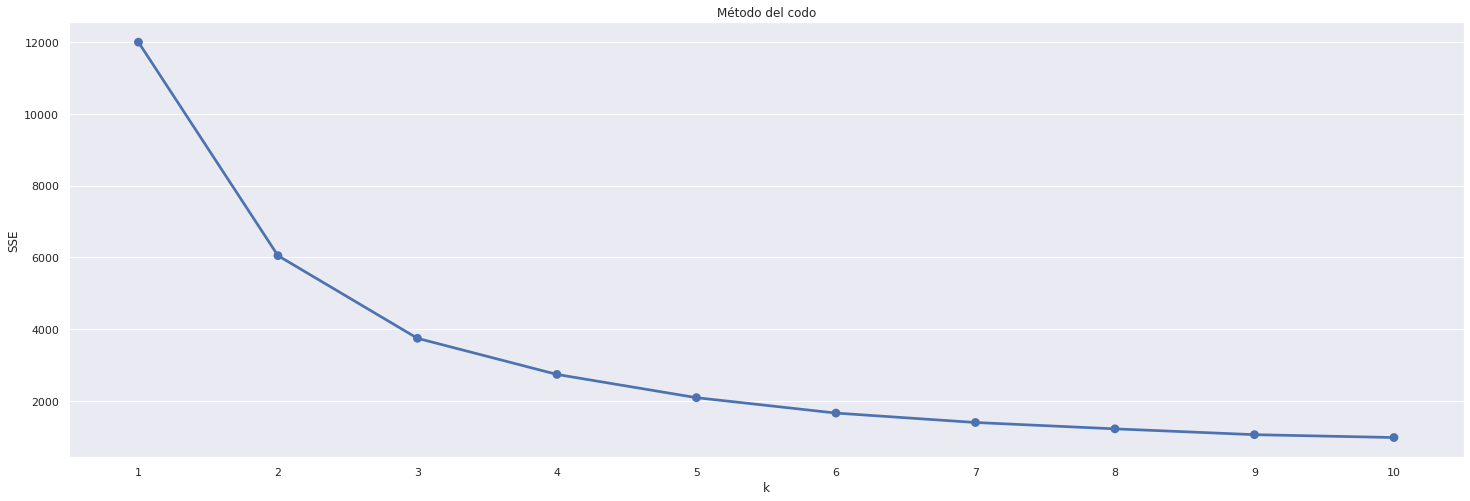

In [276]:
# Fit KMeans and calculate SSE for each *k*
sse = {}

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)    
    kmeans.fit(kmdata)  
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# Plot SSE for each *k*
plt.title('Método del codo')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Se decide usar 3 clusters, es decir, 3 segmentos de clientes

In [277]:
kmeans = KMeans(n_clusters=3, random_state=1) # Creación del modelo
kmeans.fit(kmdata) # Ajustar el modelo con los datos
cluster_labels = kmeans.labels_ # Etiquetas de cluster 

In [278]:
df['segmento']=cluster_labels # Agregar el cluster al dataset de clientes 

In [279]:
df.head()

Recency  Frequency  MonetaryValue  segmento
ID_USER                                             
0            316          2     697.064876         2
1             31          7    3416.796066         1
2            123          7    2789.893416         1
3            311          2     477.972148         2
4            310          1     277.176524         2

Resumen de los datos para cada cluster

In [280]:
df.groupby('segmento').agg({
    'Recency': ['min','max','mean'],
    'Frequency': ['min','max','mean'],
    'MonetaryValue': ['min','max','mean', 'count']}).round(1)

Recency             Frequency           MonetaryValue           \
             min  max   mean       min max  mean           min      max   
segmento                                                                  
0              1    1    1.0         2  62  11.2         385.6  32756.8   
1             31  320  120.2         3  40   8.5         987.1  19618.3   
2              1  324  227.3         1   5   1.8           2.0   1990.1   

                        
            mean count  
segmento                
0         5627.9   784  
1         4272.5  1850  
2          839.0  1366

Según esto, podríamos definir los tres segmentos de clientes y catalogarlos así:


*   **Semilla (0)**: Clientes inactivos hace 1 mes, pero que realizan entre 3 y 40 transacciones al año pero con valores entre 987 y 19 mil pesos. 
*   **Junior (1)**: Son los clientes que menos aportan valor monetario al banco y que solo realizan entre 1 y 5 transacciones al año.
*   **Platinum (2)**: Son los clientes que más hacen transacciones y que mayor valor monetario aportan al banco. Realizan por lo menos 1 transacción cada 2 meses, con valores promedio de 5627 pesos pero que llegan hasta 32.8 mil pesos.




Ahora haremos una comparación visual de las variables RFM para los 3 segmentos del banco. Se usarán los datos normalizados para que las variables sean comparables entre si. 

In [295]:
# Agregar la columna al dataset normalizado
kmdata['segmento']=df['segmento']
# Transformar los datos a formato largo
df_melt = pd.melt(kmdata.reset_index(),
                  id_vars=['ID_USER','segmento'], 
                  value_vars=['Recency','Frequency','MonetaryValue'],
                  var_name='Attribute',
                  value_name='Value')

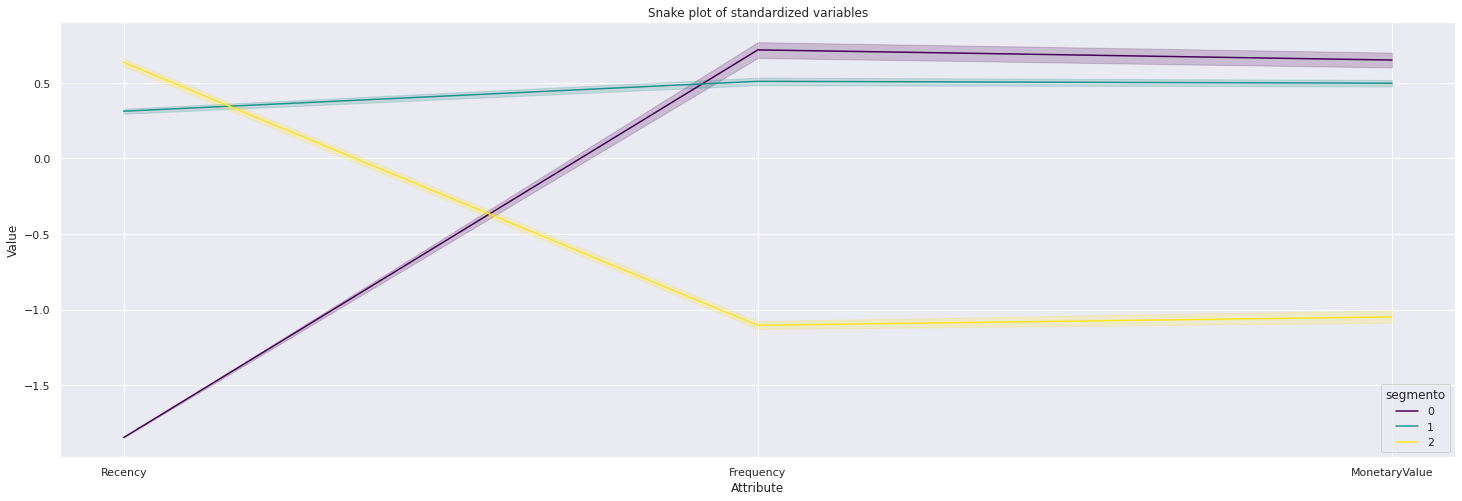

In [282]:
#@title
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='segmento', data=df_melt, palette="viridis")

# 7. Detección de Fraude

En esta sección aplicaremos un modelo de clasifiación supervisada para predecir el fraude. Un modelo posible son los árboles de decisión que suelen funcionar bien con datos desequilibrados, estos trabajan aplicando una jerarquía de preguntas if/else y esto puede obligar a que se aborden ambas clases. Sin enmbargo, en este caso aplicaremos Random Forest, un modelo que cual combina varios árboles de deicisión para tener un resultado que no se sobreajusta (overfitting) como podría suceder con los árboles de decisión. 

### Random Forest Classifier

Separamos los datos entre variables y la clase 

In [283]:
X = clsdata.drop('fraude',axis=1) 
y = clsdata.fraude
print(X.shape, y.shape)

(26975, 20) (26975,)


In [284]:
# Separando datos de entrenamiento y de prueba (Train and test data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

# Se concatenan los valores de entrenamiento nuevamente
X = pd.concat([X_train, y_train], axis=1)

# Se separan las clases 
not_fraud = X[X.fraude==0]
fraud = X[X.fraude==1]

Considerando que las operaciones con fraude (clase=1) solo representan el 3% del dataset, aplicaremos un undersampling haciendo que el los valores de la clase sean 50/50 para ambos valores de la clase. 

In [285]:
# Ajustar la muestra de valores con clase == 0 al mismo tamaño de la muestra de valores con clase == 1:
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # Muestra sin reemplazos
                                n_samples = len(fraud), # Asigna el tamaño de la muestra igual con el valor mínimo (Cuando la clase es = 1) 
                                random_state = 27) # Resultados reproducibles

# Cominar datos 
downsampled = pd.concat([not_fraud_downsampled, fraud])

# Verificar el balance
downsampled.fraude.value_counts()

0    603
1    603
Name: fraude, dtype: int64

In [286]:
# Volver a definir los datos de entrenamiento con la misma muestra
y_train = downsampled.fraude
X_train = downsampled.drop('fraude', axis=1)

# Crear el modelo
model = RandomForestClassifier(n_estimators=20,random_state=5)
# Entrenar el modelo
model.fit(X_train, y_train)
# Realizar la predicción con los datos de prueba
predicted = model.predict(X_test)

Reporte de clasifiación

In [287]:
#@title
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      0.56      0.71      6537
           1       0.03      0.45      0.06       207

    accuracy                           0.55      6744
   macro avg       0.50      0.51      0.38      6744
weighted avg       0.94      0.55      0.69      6744



Matriz de confusión

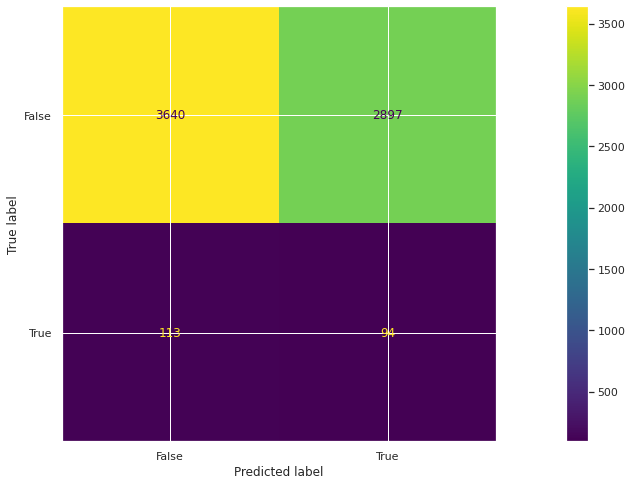

In [288]:
#@title
con_matrix=metrics.confusion_matrix(y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = con_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Para el análisis de fraude, no tiene mayor relevancia analizar métricas como accuracy o precision. Sin embargo, es importante tener un buen recall ya que no queremos tener una tasa alta de falsos negativos, esto representaría identificar muchas operaciones como no fraudulentas cuando si lo son, lo que podría representar una pérdida grande para el banco. 

Ahora análisamos la importancia de las variables en el modelo

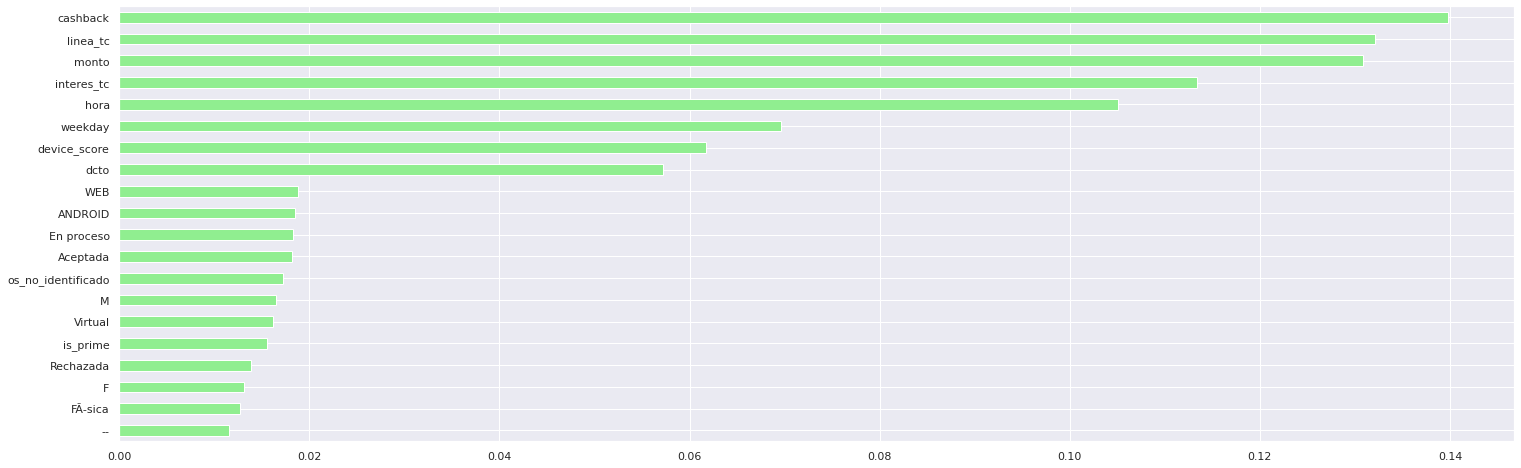

In [289]:
#@title
# Create a pd.Series of features importances
importances_rf = pd.Series(model.feature_importances_, index = X_train.columns)
# Sort importances_rf                                   
sorted_importances_rf = importances_rf.sort_values()   
# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='lightgreen'); 
plt.show()

Las variables en relación al monto de la transacción tienen una mayor incidencia en la predicción, así como la linea de crédito. Otras variables como el tipo de tarjeta, el sexo y el estado de la transacción no parecen tener mayor incidencia, por lo que podrían omitirse para buscar optimizar el modelo. 

**Optimización del modelo:**

Para este caso práctico, buscaremos optimizar el modelo mejorando el recall identificando el número de árboles óptimos para usar en el clasificador. Para esto aplicaremos una técnica llamada validación cruzada que nos permita identificar la mejor opción entre los valores dados. 

In [290]:
# Define the grid of hyperparameters 'params_dt'
params_model = {
    'n_estimators':[10,12,15,17,20]
    }
# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_model = GridSearchCV(estimator=model,                        
                       param_grid=params_model,                       
                       scoring='recall',                                              
                       cv=10,                       
                       n_jobs=-1)
# Fit 'grid_dt' to the training data
grid_model.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=RandomForestClassifier(n_estimators=20, random_state=5),
             n_jobs=-1, param_grid={'n_estimators': [10, 12, 15, 17, 20]},
             scoring='recall')

In [291]:
# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_model.best_params_
print('Best hyerparameters:\n', best_hyperparams)

Best hyerparameters:
 {'n_estimators': 15}


In [292]:
# Extract best CV score from 'grid_dt'
best_CV_score = grid_model.best_score_
print(f'Best CV recall: {round(best_CV_score,3)*100}%')

Best CV recall: 50.0%


Con un número de árboles de 15, es posible tener un recall de 50%, logrando un mejor performance del modelo en comparación al logrado inicialmente con 20 árboles. 

Finalmente guardamos el modelo como archivo pickl para luego ponerlo en producción en AWS

In [293]:
# Se graba el modelo en el directorio
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

# 8. Conclusiones, consideraciones y próximos pasos

**Conclusiones**

1.   Se analizaron los datos correspondientes a 26975 transacciones de tarjeta de crédito realizados en 4 ciudades de méxico, se encontró que algunas variables como el monto podrían tener relación con operaciones fraudulentas. Se encontró que solo el 3% de las operaciones fueron catalogadas como fraude.
2. Para los cuatro mil (4000) clientes del banco se propuso una segmentación de clientes basandose en los parémtros RFM (Recency, Frequency y Monetary Value). Los 3 segmentos fueron llamados Semilla, Junior y Platinum.
3. Se desarrolló un modelo de clasificación supervisada Random Forest, el cual se optimizó usando validación cruzada para obtener un recall máximo de 50%. El modelo se corrió con un undersampling de los datos originales, buscando que las clases estuvieran balanceadas 50/50. 

> 

**Consideraciones**


1. Para los segmentos de clientes, el banco puede establecer una estrategia individual para cada uno, buscando que el segmento Junior conozca mejor la importancia de usar productos de crédito, que el segmento semilla se convierta a futuro en Platinum y que el segmento Platinum tenga la retención más alta para seguir aportando valor al banco. Esta estrategia podrá derivar mejoras en los productos, creación de beneficios adicionales y campañas de comunicación personalizadas en medios tanto digitales como tradicionales. La estrategia deberá plantearse según investigaciones más profundas centradas en cada uno de los segmentos del banco y en factores externos como análisis de competidores. 
2. Teniendo en cuenta que el modelo de predicción de fraude fue entrenado con un undersampling, muchos datos fueron descartados. Lo ideal si se va a aplicar esta técnica es tener un número de transacciones fraudulentas lo suficientemente grande en la base inicial para contar con un volúmen de datos altos. Con el modelo actual la predicción no es acertada aunque sigue siendo mejor para identificar transacciones fraudulentas que haber corrido el modelo con el total de los datos, ya que debido al desbalance, todas hubieran sido clasificadas como legítimas, teniendo un accuracy de 97% pero un recall de 0%. Lo cual es extremo perjudicial para este ejercicio.
3. En próximas versiones, el modelo de detección de fraude se puede optimizar más evaluando otros hiperparámetros y combinaciones de datos de entrenamiento, así como descartando variables que no demuestran tener relevancia en la predicción.   






